# Post-Training Quantization with TensorFlow Classification Model

This example demonstrates how to quantize the OpenVINO model that was created in [301-tensorflow-training-openvino.ipynb](301-tensorflow-training-openvino.ipynb), to improve inference speed. Quantization is performed with [Post-training Quantization with NNCF](https://docs.openvino.ai/nightly/basic_quantization_flow.html). A custom dataloader and metric will be defined, and accuracy and performance will be computed for the original IR model and the quantized model.

## Preparation

The notebook requires that the training notebook has been run and that the Intermediate Representation (IR) models are created. If the IR models do not exist, running the next cell will run the training notebook. This will take a while.

In [1]:
from pathlib import Path

import tensorflow as tf

model_xml = Path("model/flower/flower_ir.xml")
dataset_url = (
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
)
data_dir = Path(tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True))

if not model_xml.exists():
    print("Executing training notebook. This will take a while...")
    %run 301-tensorflow-training-openvino.ipynb

2023-06-12 19:24:16.827516: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 19:24:16.989853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 19:24:17.982409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Imports

The Post Training Quantization API is implemented in the `nncf` library.

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import nncf
from openvino.runtime import Core
from openvino.runtime import serialize
from PIL import Image
from sklearn.metrics import accuracy_score

sys.path.append("../utils")
from notebook_utils import download_file

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


## Post-training Quantization with NNCF

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.

Create a quantized model from the pre-trained FP32 model and the calibration dataset. The optimization process contains the following steps:
1. Create a Dataset for quantization.
2. Run nncf.quantize for getting an optimized model.

The validation dataset already defined in the training notebook.

In [3]:
img_height = 180
img_width = 180
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1
)

for a, b in val_dataset:
    print(type(a), type(b))
    break

Found 3670 files belonging to 5 classes.
Using 734 files for validation.
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


2023-06-12 19:24:21.505512: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-12 19:24:21.581206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [734]
	 [[{{node Placeholder/_4}}]]
2023-06-12 19:24:21.581450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'P

The validation dataset can be reused in quantization process. But it returns a tuple (images, labels), whereas calibration_dataset should only return images. The transformation function helps to transform a user validation dataset to the calibration dataset.

In [4]:
def transform_fn(data_item):
    """
    The transformation function transforms a data item into model input data.
    This function should be passed when the data item cannot be used as model's input.
    """
    images, _ = data_item
    return images.numpy()


calibration_dataset = nncf.Dataset(val_dataset, transform_fn)

Download Intermediate Representation (IR) model.

In [5]:
ie = Core()
ir_model = ie.read_model(model_xml)

Use [Basic Quantization Flow](https://docs.openvino.ai/2023.0/basic_qauntization_flow.html#doxid-basic-qauntization-flow). To use the most advanced quantization flow that allows to apply 8-bit quantization to the model with accuracy control see [Quantizing with accuracy control](https://docs.openvino.ai/2023.0/quantization_w_accuracy_control.html#).

In [6]:
quantized_model = nncf.quantize(
    ir_model,
    calibration_dataset,
    subset_size=1000
)

Biases correction: 100%|██████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Save quantized model to benchmark.

In [7]:
compressed_model_dir = Path("model/optimized")
compressed_model_dir.mkdir(parents=True, exist_ok=True)
compressed_model_xml = compressed_model_dir / "flower_ir.xml"
serialize(quantized_model, str(compressed_model_xml))

## Compare Metrics
Define a metric to determine the performance of the model.

For this demo we define validate function to compute accuracy metrics.

In [8]:
def validate(model, validation_loader):
    """
    Evaluate model and compute accuracy metrics.

    :param model: Model to validate
    :param validation_loader: Validation dataset
    :returns: Accuracy scores
    """
    predictions = []
    references = []

    output = model.outputs[0]

    for images, target in validation_loader:
        pred = model(images.numpy())[output]

        predictions.append(np.argmax(pred, axis=1))
        references.append(target)

    predictions = np.concatenate(predictions, axis=0)
    references = np.concatenate(references, axis=0)

    scores = accuracy_score(references, predictions)

    return scores

Calculate accuracy for the original model and the quantized model.

In [9]:
original_compiled_model = ie.compile_model(model=ir_model, device_name="CPU")
quantized_compiled_model = ie.compile_model(model=quantized_model, device_name="CPU")

original_accuracy = validate(original_compiled_model, val_dataset)
quantized_accuracy = validate(quantized_compiled_model, val_dataset)

print(f"Accuracy of the original model: {original_accuracy:.3f}")
print(f"Accuracy of the quantized model: {quantized_accuracy:.3f}")

Accuracy of the original model: 0.732
Accuracy of the quantized model: 0.736


Compare file size of the models.

In [10]:
original_model_size = model_xml.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = compressed_model_xml.with_suffix(".bin").stat().st_size / 1024

print(f"Original model size: {original_model_size:.2f} KB")
print(f"Quantized model size: {quantized_model_size:.2f} KB")

Original model size: 7791.65 KB
Quantized model size: 3897.08 KB


So, we can see that the original and quantized models have similar accuracy with a much smaller size of the quantized model.

## Run Inference on Quantized Model

Copy the preprocess function from the training notebook and run inference on the quantized model with Inference Engine. See the [OpenVINO API tutorial](../002-openvino-api/002-openvino-api.ipynb) for more information about running inference with Inference Engine Python API.

In [11]:
def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)

    input_image = image.reshape((n, h, w, c))

    return input_image

'output/A_Close_Up_Photo_of_a_Dandelion.jpg' already exists.
input image shape: (1, 180, 180, 3)
input layer shape: [1,180,180,3]
This image most likely belongs to dandelion with a 99.01 percent confidence.


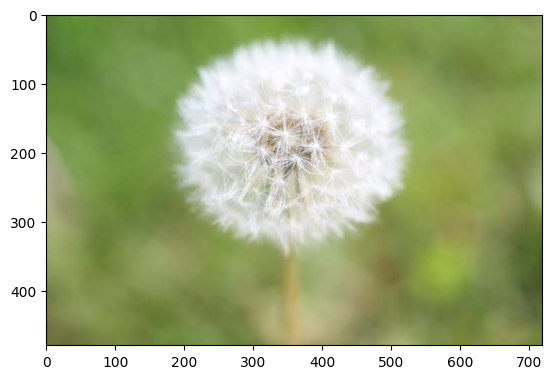

In [12]:
# Get the names of the input and output layer
# model_pot = ie.read_model(model="model/optimized/flower_ir.xml")
input_layer = quantized_compiled_model.input(0)
output_layer = quantized_compiled_model.output(0)

# Get the class names: a list of directory names in alphabetical order
class_names = sorted([item.name for item in Path(data_dir).iterdir() if item.is_dir()])

# Run inference on an input image...
inp_img_url = (
    "https://upload.wikimedia.org/wikipedia/commons/4/48/A_Close_Up_Photo_of_a_Dandelion.jpg"
)
directory = "output"
inp_file_name = "A_Close_Up_Photo_of_a_Dandelion.jpg"
file_path = Path(directory)/Path(inp_file_name)
# Download the image if it does not exist yet
if not Path(inp_file_name).exists():
    download_file(inp_img_url, inp_file_name, directory=directory)

# Pre-process the image and get it ready for inference.
input_image = pre_process_image(imagePath=file_path)
print(f'input image shape: {input_image.shape}')
print(f'input layer shape: {input_layer.shape}')

res = quantized_compiled_model([input_image])[output_layer]

score = tf.nn.softmax(res[0])

# Show the results
image = Image.open(file_path)
plt.imshow(image)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(
        class_names[np.argmax(score)], 100 * np.max(score)
    )
)

## Compare Inference Speed

Measure inference speed with the [OpenVINO Benchmark App](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html).

Benchmark App is a command line tool that measures raw inference performance for a specified OpenVINO IR model. Run `benchmark_app --help` to see a list of available parameters. By default, Benchmark App tests the performance of the model specified with the `-m` parameter with asynchronous inference on CPU, for one minute. Use the `-d` parameter to test performance on a different device, for example an Intel integrated Graphics (iGPU), and `-t` to set the number of seconds to run inference. See the [documentation](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html) for more information.

This tutorial uses a wrapper function from [Notebook Utils](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/utils/notebook_utils.ipynb). It prints the `benchmark_app` command with the chosen parameters.

In the next cells, inference speed will be measured for the original and quantized model on CPU. If an iGPU is available, inference speed will be measured for CPU+GPU as well. The number of seconds is set to 15.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [13]:
# print the available devices on this system
print("Device information:")
print(ie.get_property("CPU", "FULL_DEVICE_NAME"))
if "GPU" in ie.available_devices:
    print(ie.get_property("GPU", "FULL_DEVICE_NAME"))

Device information:
Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz
NVIDIA GeForce GTX 1080 Ti (dGPU)


In [14]:
# Original model - CPU
! benchmark_app -m $model_xml -d CPU -t 15 -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 8.23 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     sequential_1_input (node: sequential_1_input) : f32 / [...] / [1,180,180,3]
[ INFO ] Model outputs:
[ INFO ]     outputs (node: sequential_2/outputs/BiasAdd) : f32 / [...] / [1,5]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ]

In [15]:
# Quantized model - CPU
! benchmark_app -m $compressed_model_xml -d CPU -t 15 -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 4.54 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     sequential_1_input (node: sequential_1_input) : f32 / [...] / [1,180,180,3]
[ INFO ] Model outputs:
[ INFO ]     outputs (node: sequential_2/outputs/BiasAdd) : f32 / [...] / [1,5]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ]

**Benchmark on MULTI:CPU,GPU**

With a recent Intel CPU, the best performance can often be achieved by doing inference on both the CPU and the iGPU, with OpenVINO's [Multi Device Plugin](https://docs.openvino.ai/2021.4/openvino_docs_IE_DG_supported_plugins_MULTI.html). It takes a bit longer to load a model on GPU than on CPU, so this benchmark will take a bit longer to complete than the CPU benchmark, when run for the first time. Benchmark App supports caching, by specifying the `--cdir` parameter. In the cells below, the model will cached to the `model_cache` directory.

In [16]:
# Original model - MULTI:CPU,GPU
if "GPU" in ie.available_devices:
    ! benchmark_app -m $model_xml -d MULTI:CPU,GPU -t 15 -api async
else:
    print("A supported integrated GPU is not available on this system.")

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] GPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] MULTI
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(MULTI) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 5.49 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     sequential_1_input (node: sequential_1

In [17]:
# Quantized model - MULTI:CPU,GPU
if "GPU" in ie.available_devices:
    ! benchmark_app -m $compressed_model_xml -d MULTI:CPU,GPU -t 15 -api async
else:
    print("A supported integrated GPU is not available on this system.")

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] GPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] MULTI
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(MULTI) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 4.41 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     sequential_1_input (node: sequential_1

In [18]:
# print the available devices on this system
print("Device information:")
print(ie.get_property("CPU", "FULL_DEVICE_NAME"))
if "GPU" in ie.available_devices:
    print(ie.get_property("GPU", "FULL_DEVICE_NAME"))

Device information:
Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz
NVIDIA GeForce GTX 1080 Ti (dGPU)


**Original IR model - CPU**

In [19]:
benchmark_output = %sx benchmark_app -m $model_xml -t 15 -api async
# Remove logging info from benchmark_app output and show only the results
benchmark_result = benchmark_output[-8:]
print("\n".join(benchmark_result))

[ INFO ] Count:            71802 iterations
[ INFO ] Duration:         15004.38 ms
[ INFO ] Latency:
[ INFO ]    Median:        3.34 ms
[ INFO ]    Average:       3.49 ms
[ INFO ]    Min:           1.48 ms
[ INFO ]    Max:           25.28 ms
[ INFO ] Throughput:   4785.40 FPS


**Quantized IR model - CPU**

In [20]:
benchmark_output = %sx benchmark_app -m $compressed_model_xml -t 15 -api async
# Remove logging info from benchmark_app output and show only the results
benchmark_result = benchmark_output[-8:]
print("\n".join(benchmark_result))

[ INFO ] Count:            225864 iterations
[ INFO ] Duration:         15001.82 ms
[ INFO ] Latency:
[ INFO ]    Median:        1.00 ms
[ INFO ]    Average:       1.06 ms
[ INFO ]    Min:           0.59 ms
[ INFO ]    Max:           25.75 ms
[ INFO ] Throughput:   15055.78 FPS


**Original IR model - MULTI:CPU,GPU**

With a recent Intel CPU, the best performance can often be achieved by doing inference on both the CPU and the iGPU, with OpenVINO's [Multi Device Plugin](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Running_on_multiple_devices.html). It takes a bit longer to load a model on GPU than on CPU, so this benchmark will take a bit longer to complete than the CPU benchmark.

In [21]:
if "GPU" in ie.available_devices:
    benchmark_output = %sx benchmark_app -m $model_xml -d MULTI:CPU,GPU -t 15 -api async
    # Remove logging info from benchmark_app output and show only the results
    benchmark_result = benchmark_output[-8:]
    print("\n".join(benchmark_result))
else:
    print("An GPU is not available on this system.")

[Step 10/11] Measuring performance (Start inference asynchronously, 22 inference requests, limits: 15000 ms duration)
[ INFO ] Benchmarking in inference only mode (inputs filling are not included in measurement loop).
[ INFO ] First inference took 8.10 ms
[Step 11/11] Dumping statistics report
[ INFO ] Execution Devices:['CPU', 'GPU']
[ INFO ] Count:            71434 iterations
[ INFO ] Duration:         15006.11 ms
[ INFO ] Throughput:   4760.33 FPS


**Quantized IR model - MULTI:CPU,GPU**

In [22]:
if "GPU" in ie.available_devices:
    benchmark_output = %sx benchmark_app -m $compressed_model_xml -d MULTI:CPU,GPU -t 15 -api async
    # Remove logging info from benchmark_app output and show only the results
    benchmark_result = benchmark_output[-8:]
    print("\n".join(benchmark_result))
else:
    print("An GPU is not available on this system.")

[Step 10/11] Measuring performance (Start inference asynchronously, 274 inference requests, limits: 15000 ms duration)
[ INFO ] Benchmarking in inference only mode (inputs filling are not included in measurement loop).
[ INFO ] First inference took 2.05 ms
[Step 11/11] Dumping statistics report
[ INFO ] Execution Devices:['CPU', 'GPU']
[ INFO ] Count:            210158 iterations
[ INFO ] Duration:         15470.29 ms
[ INFO ] Throughput:   13584.62 FPS
